In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price
from get_data import get_option_data
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test
from evaluation import get_eval_data

import seaborn as sns

In [70]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [71]:
option_dfs = {}
filenames = []
for file_name in glob.glob("data/"+'*.csv'):
    filenames.append(file_name[5:-4])
    option_id = file_name[5:-4]
    option_dfs[option_id]  = pd.read_csv(file_name, index_col=0)

120514885

119327510


In [148]:
option_df = option_dfs["119327507"]
option_df.head()

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,optionid,forward_price,index_flag,issuer,exercise_style,S
3393812,112878,2018-06-15,2018-06-15,20180615.0,C,1240000,16.2,18.3,1,0.104759,119327507,NaN,1,CBOE S&P 100 INDEX,E,1220.260010
3395658,112878,2018-06-18,2018-06-18,20180615.0,C,1240000,14.7,16.7,0,0.104422,119327507,NaN,1,CBOE S&P 100 INDEX,E,1217.339966
3397598,112878,2018-06-19,2018-06-19,20180615.0,C,1240000,13.4,15.6,0,0.106009,119327507,NaN,1,CBOE S&P 100 INDEX,E,1213.239990
3399538,112878,2018-06-20,2018-06-20,20180615.0,C,1240000,13.8,15.5,0,0.104057,119327507,NaN,1,CBOE S&P 100 INDEX,E,1215.290039
3401680,112878,2018-06-21,2018-06-21,20180615.0,C,1240000,11.4,13.0,0,0.105664,119327507,NaN,1,CBOE S&P 100 INDEX,E,1207.079956


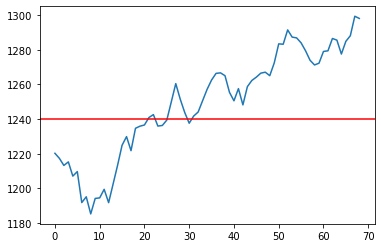

In [149]:
option_df.reset_index().S.plot()
plt.axhline(y=option_df["strike_price"].iloc[0] / 1000, color='r', linestyle='-')

In [150]:
option_df.shape

(69, 16)

In [151]:
# Get params dependent on data
strike, sigma, n_steps, initial_value, x, x_inc, payoff, price = get_eval_data(option_df)

In [153]:
# Remaining params to determine
n_simulations = 15_000
rf = 0
fc_dims = [32, 32, 32]
LR = 0.005
EPOCHS = 30
BATCH_SIZE = 250

In [154]:
# Using implied volatility should give back market price 
price, bs_call_price(n_steps, initial_value, sigma, rf, strike)

(17.25, 13.700868506574523)

In [155]:
bs_params = {"n_simulations": n_simulations,
             "n_steps": n_steps,
             "initial_value": initial_value,
             "sigma": sigma,
             }

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": rf,
                "strike": strike,
                }

payoff_params = {"strike": strike}

cn = ControlNet(n_steps, 1, fc_dims, 1, learn_price=True)
optimizer = Adam(cn.parameters(), lr=LR)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = torch.nn.MSELoss()

dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
data_loader_train = DataLoader(dt, batch_size=BATCH_SIZE, shuffle=True)
train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer, scheduler)

Epoch 0: : 0batch [00:00, ?batch/s]/opt/anaconda3/envs/deep_hedging/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([250])) that is different to the input size (torch.Size([250, 250])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 60batch [00:23,  2.50batch/s, loss=31.7]  
Epoch 1: : 60batch [00:23,  2.51batch/s, loss=12.8]
Epoch 2: : 60batch [00:23,  2.56batch/s, loss=22.3]
Epoch 3: : 60batch [00:24,  2.42batch/s, loss=17.2]
Epoch 4: : 60batch [00:25,  2.37batch/s, loss=18.7]
Epoch 5: : 60batch [00:23,  2.52batch/s, loss=12.7]
Epoch 6: : 60batch [00:23,  2.52batch/s, loss=14.2]
Epoch 7: : 60batch [00:23,  2.53batch/s, loss=12.6]
Epoch 8: : 60batch [00:23,  2.54batch/s, loss=20]  
Epoch 9: : 60batch [00:23,  2.51batch/s, loss=14.3]
Epoch 10: : 60batch [00:23,  2.54batch/s, loss=19.7]
Epoch 11: : 60batch 

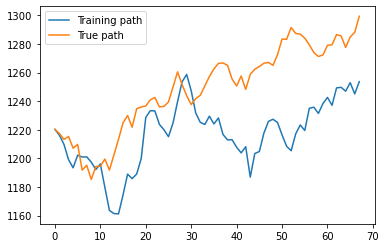

In [156]:
# Visualize an example training path and the true path

a, b, c, d, = next(iter(data_loader_train))
plt.plot(a[0], label="Training path")
plt.plot(x.squeeze(), label="True path")
plt.legend()

In [157]:
x.shape

torch.Size([1, 68, 1])

In [158]:
print(f"{price=}")

# Model
cn.eval_mode()

hedge, learned_price = cn(x)
si = stochastic_integral(torch.Tensor(x_inc), hedge)

print(f"{learned_price=}")  # this is roughly BS price using the imp. vola

ml_mkt_price = (price + si - payoff) ** 2
ml_learned_price = (learned_price + si - payoff) ** 2
print(f"{ml_mkt_price=}")
print(f"{ml_learned_price=}")

# Delta hedge benchmark
def delta(x):
    return bs_delta(n_steps, x, sigma, rf, strike)

d_hedge = torch.Tensor([delta(i) for i in x.squeeze()])
si = stochastic_integral(x_inc, d_hedge)
dl_mkt_price = (price + si - payoff) ** 2
dl_learned_price = (learned_price + si - payoff) ** 2
 
print(f"{dl_mkt_price=}")
print(f"{dl_learned_price=}")

price=17.25
learned_price=tensor([[18.2510]], grad_fn=<AddmmBackward>)
ml_mkt_price=tensor(5.6334, grad_fn=<PowBackward0>)
ml_learned_price=tensor([[11.3869]], grad_fn=<PowBackward0>)
dl_mkt_price=tensor(1.1605)
dl_learned_price=tensor([[0.0058]], grad_fn=<PowBackward0>)


In [110]:
# Remaining params to determine
n_simulations = 10_000
rf = 0
fc_dims = [32, 32, 32]
LR = 0.005
EPOCHS = 20
BATCH_SIZE = 1000

In [111]:
output = {}
for optionid in filenames:
    #Get data
    option_df = option_dfs[optionid]

    # Get params dependent on data
    strike, sigma, n_steps, initial_value, x, x_inc, payoff, price = get_eval_data(option_df)

    # Using implied volatility should give back market price 
    price, bs_call_price(n_steps, initial_value, sigma, rf, strike)

    #Train
    bs_params = {"n_simulations": n_simulations,
                 "n_steps": n_steps,
                 "initial_value": initial_value,
                 "sigma": sigma,
                 }

    price_params = {"n_steps": n_steps,
                    "initial_value": initial_value,
                    "sigma": sigma,
                    "rf": rf,
                    "strike": strike,
                    }

    payoff_params = {"strike": strike}

    cn = ControlNet(n_steps, 1, fc_dims, 1, learn_price=True)
    optimizer = Adam(cn.parameters(), lr=LR)
    scheduler = ExponentialLR(optimizer, gamma=0.95)
    criterion = torch.nn.MSELoss()

    dt = SimulationData(bs_generator, bs_params, lambda x: x, {"x": price}, call_payoff, payoff_params)
    data_loader_train = DataLoader(dt, batch_size=BATCH_SIZE, shuffle=True)
    train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer, scheduler)

    # Model
    cn.eval_mode()

    hedge, learned_price = cn(x)
    si = stochastic_integral(torch.Tensor(x_inc), hedge)

    ml_mkt_price = (price + si - payoff) ** 2
    ml_learned_price = (learned_price + si - payoff) ** 2

    # Delta hedge benchmark
    def delta(x):
        return bs_delta(n_steps, x, sigma, rf, strike)

    d_hedge = torch.Tensor([delta(i) for i in x.squeeze()])
    si = stochastic_integral(x_inc, d_hedge)
    dl_mkt_price = (price + si - payoff) ** 2
    dl_learned_price = (learned_price + si - payoff) ** 2
    
    output[optionid] = [price, bs_call_price(n_steps, initial_value, sigma, rf, strike)\
                        , learned_price.detach().numpy()[0][0], ml_mkt_price.detach().numpy().item(0)\
                        , ml_learned_price.detach().numpy().item(0), dl_mkt_price.detach().numpy().item(0)\
                        , dl_learned_price.detach().numpy().item(0)]
    



Epoch 0: : 0batch [00:00, ?batch/s]/opt/anaconda3/envs/deep_hedging/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 10batch [00:07,  1.32batch/s, loss=5.21e+3]
Epoch 1: : 10batch [00:07,  1.29batch/s, loss=4.27e+3]
Epoch 2: : 10batch [00:07,  1.37batch/s, loss=3.53e+3]
Epoch 3: : 10batch [00:07,  1.39batch/s, loss=2.21e+3]
Epoch 4: : 10batch [00:07,  1.40batch/s, loss=633]   
Epoch 5: : 10batch [00:06,  1.44batch/s, loss=83.9]
Epoch 6: : 10batch [00:07,  1.36batch/s, loss=91.6]
Epoch 7: : 10batch [00:07,  1.39batch/s, loss=30] 
Epoch 8: : 10batch [00:07,  1.42batch/s, loss=29.8]
Epoch 9: : 10batch [00:07,  1.41batch/s, loss=18.9]
Epoch 10: : 10batch [00:06,  1.43batch/s, loss=19.6]
Epoch 

Epoch 2: : 10batch [00:09,  1.06batch/s, loss=7.87]
Epoch 3: : 10batch [00:09,  1.05batch/s, loss=5.79]
Epoch 4: : 10batch [00:09,  1.03batch/s, loss=3.81]
Epoch 5: : 10batch [00:09,  1.05batch/s, loss=4.44]
Epoch 6: : 10batch [00:09,  1.05batch/s, loss=3.59]
Epoch 7: : 10batch [00:09,  1.04batch/s, loss=3.94]
Epoch 8: : 10batch [00:09,  1.05batch/s, loss=3.38]
Epoch 9: : 10batch [00:09,  1.05batch/s, loss=2.81]
Epoch 10: : 10batch [00:09,  1.04batch/s, loss=5.78]
Epoch 11: : 10batch [00:09,  1.05batch/s, loss=3.24]
Epoch 12: : 10batch [00:09,  1.05batch/s, loss=3.04]
Epoch 13: : 10batch [00:09,  1.02batch/s, loss=5.53]
Epoch 14: : 10batch [00:09,  1.04batch/s, loss=2.77]
Epoch 15: : 10batch [00:09,  1.05batch/s, loss=2.94]
Epoch 16: : 10batch [00:09,  1.04batch/s, loss=2.72]
Epoch 17: : 10batch [00:09,  1.04batch/s, loss=3.44]
Epoch 18: : 10batch [00:09,  1.05batch/s, loss=2.71]
Epoch 19: : 10batch [00:10,  1.02s/batch, loss=4.12]
Epoch 0: : 10batch [00:06,  1.55batch/s, loss=264]   


In [113]:
df_output = pd.DataFrame.from_dict(output, orient='index', columns=['price', 'bs_call_price', 'learned_price', 'ml_mkt_price', 'ml_learned_price', 'dl_mkt_price', 'dl_learned_price'])

In [114]:
df_output.to_csv('output.csv')